# Welcome to the stream analytics lab 

The purpose of this lab is to acquaint you with some basic techniques in stream analytics. We will study two sketches, the Count-min sketch and the AMS sketch. Our goal will be to construct some sketches, perform some queries on them and determine experimentally their error and probabilistic characteristics.

Our lab excercises will be performed completely through your web browser, in the Jupyter environment (the web page you are reading right now!) and will be done in Python. If you are unfamiliar with the Python programming language, do not worry too much; for one thing, Python is probably the easiest language to learn, and you can always get help from the lab instructors.

## First steps

First, you need to make a copy of this page, so that you can begin to edit it.

In the **File** menu (on the top left of the screen) select the 'Make a Copy...' item

** __DO THIS NOW__ **

If all went well, the name at the top of the screen has now changed from `lab_guide` to something like `lab_guide-CopyNN`.  Using again the **File** menu, you can rename the page to something friendlier, e.g.
`lab_guide-AlanTuring` (assuming you __are__ Alan...)




## Getting around this page

We are now ready to start with the lab. First, we need to familiarize ourselves with Jupyter. This page is organized in a number of cells. Some cells (like the one you are reading) are text cells, and some cells are 
Python code. 

You can click on any cell and edit its contents. Once you have edited a cell, you can type **Ctrl-Enter** to execute the cell.  Text cells execute by formatting their text nicely (using github markup). Python cells execute the Python code in a background interpreter and display all kinds of output.

For example, in the next cell, we are executing a Python expression:

In [1]:
1+1

2

# Loading the python file to use

There is some code that you can use for the lab. It is included in file lab.py. You can see the source code at the following link (https://github.com/vsamtuc/ssch17/blob/master/lab.py)

In [2]:
from lab import *

Now, let us create some data

In [3]:
data = make_random_data(10, 20)
data

array([4, 9, 3, 2, 6, 6, 2, 7, 5, 0, 2, 7, 1, 3, 3, 5, 9, 7, 4, 9])

We created an array of 20 random integers, each in the range 0 to 9 (inclusive).

Let us now create the frequency vector for this data

In [4]:
dfv = frequency_vector(data)
dfv

Counter({0: 1, 1: 1, 2: 3, 3: 3, 4: 2, 5: 2, 6: 2, 7: 3, 9: 3})

## Sketching with families of hash functions

A sketch (either Count-min or AMS) requires some family of hash functions. The number of hash functions in the family is called the **depth** of the sketch. The number of hash functions is $\Theta(\log \frac{1}{\delta})$ where $\delta$ is the probability of failure for a query.

Also, a sketch has a **width**, which is the number of counters per depth used. The width is $\Theta(\frac{1}{\epsilon})$ for CM-sketches and $\Theta(\frac{1}{\epsilon^2})$ for AMS sketches, where $\epsilon$ is the accuracy of the sketch.

The two quantities, width and depth, combine into a projection object.

In [5]:
proj = projection(10,3)  # width = 10, depth = 3
print('width = ', proj.width)
print('depth = ', proj.depth)
print('hash family = ', proj.hf)

print("Hashing key 4 = ", proj.hash(4))

width =  10
depth =  3
hash family =  <lab.hash_family object at 0x7ff7880ea9e8>
Hashing key 4 =  [6 6 9]


### CM sketches

Now, using the projection we can create a CM sketch for our data.

In [6]:
cmsk = make_count_min_sketch(proj, dfv)

print("The array for the sketch\n",cmsk.vec)

print("Locations for key 5", cmsk.proj.hash(5))
print("CM sketch counts for key 5 = ", cmsk.vec[range(cmsk.proj.depth), cmsk.proj.hash(5)])
print("True count for key 5 = ", dfv[5])

The array for the sketch
 [[ 2.  0.  2.  3.  0.  3.  6.  1.  0.  3.]
 [ 5.  1.  3.  0.  2.  1.  2.  6.  0.  0.]
 [ 0.  1.  4.  0.  3.  2.  2.  3.  0.  5.]]
Locations for key 5 [0 0 6]
CM sketch counts for key 5 =  [ 2.  5.  2.]
True count for key 5 =  2


### AMS sketches

We can also create a FastAGMS sketch

In [7]:
amsk = make_ams_sketch(proj, dfv)

print("The array for the sketch\n", amsk.vec)

print("Locations for key 5", amsk.proj.hash(5))
print("CM sketch counts for key 5 = ", amsk.vec[range(cmsk.proj.depth), cmsk.proj.hash(5)])
print("True count for key 5 = ", dfv[5])

The array for the sketch
 [[ 2.  0. -2.  3.  0.  3. -6.  1.  0.  3.]
 [ 5. -1.  3.  0.  2. -1.  2. -6.  0.  0.]
 [ 0. -1.  2.  0.  3. -2.  2.  3.  0.  1.]]
Locations for key 5 [0 0 6]
CM sketch counts for key 5 =  [ 2.  5.  2.]
True count for key 5 =  2


Of course, AMS sketches are not very good at point queries. Let us see if our sketch does better in computing the second moment of the frequency vector

In [8]:
print("Inner product estimate of AMS sketch =", amsk @ amsk)
print("Exact inner product from freq.vector =", frequency_vector_inner(dfv, dfv))

Inner product estimate of AMS sketch = 72.0
Exact inner product from freq.vector = 50


Populating the interactive namespace from numpy and matplotlib


/home/minos/school/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 8.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

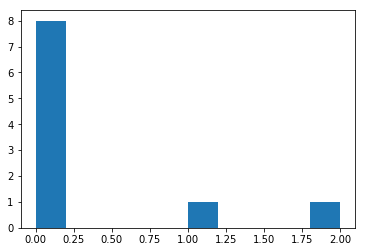

In [9]:
%pylab inline
import pandas as pd

# this is a point query for CM sketches
def cm_query(cmsk, x):
    return np.min(cmsk.vec[range(cmsk.proj.depth), cmsk.proj.hash(x)])


# Let us compute the difference between the counts from CM sketches and the freq.vector

keys = pd.Series(list(range(10)))
fvcounts = pd.Series([dfv[key] for key in keys])
cmcounts = pd.Series([cm_query(cmsk, key) for key in keys ])
dcount = cmcounts - fvcounts
hist(dcount)

##  Working with 'big data'

We can now experiment with a larger dataset, obtained from the WorldCup site: (http://ita.ee.lbl.gov/html/contrib/WorldCup.html)

The following code loads the some 7 million records from a file and selects one of the attributes as key

In [10]:
WCUP = read_wcup_native('wc_day44_1')

print(WCUP)
print(WCUP.dtype)

wcdata = WCUP['clientID']
wcdata

[(897256801,    2703,  241,        259, 0,  66, 1, 99)
 (897256801,  423679,  323,          0, 0, 141, 1, 99)
 (897256801,  797852,  219,          0, 0,  77, 1, 99) ...,
 (897310251,  796717, 1356,      12349, 0,  66, 1, 99)
 (897310251, 1209201,    5,       1504, 0,  66, 1, 99)
 (897310251,   12300,  184, 4294967295, 0,  77, 1, 99)]
[('timestamp', '>u4'), ('clientID', '>u4'), ('objectID', '>u4'), ('size', '>u4'), ('method', 'u1'), ('status', 'u1'), ('type', 'u1'), ('server', 'u1')]


array([   2703,  423679,  797852, ...,  796717, 1209201,   12300], dtype=uint32)

##  How to continue

You can now proceed as above, repeating the experiments with a large dataset. Your goals are:
 * Create a frequency vector for the data in the `wcdata` array
 * Create a CM sketch and plot the distribution of error in point queries
 * Using AMS sketches, create a plot of the distribution of error in estimation of the norm, for AMS sketches of    different widths